Gestandaardiseerde data vorm: (66, 347)
VALIDATIEDATUM: 2020-01
((66, 300), (54, 300), (66, 289), (54, 300), (66, 289))
PCA factoren vorm: (9, 54)
Yule-Walker schatting vorm: (10, 9)
ElasticNet B_matrix vorm: (300, 9)
RMSE: [0.40551714 0.33871533 0.38519804 0.46037078 0.31557524 0.39783804
 0.39400359 0.31726648 0.32533571 0.25779757 0.31438289 0.32420367
 0.261863   0.23067382 0.17857007 0.21551808 0.20970862 0.17048056
 0.17841724 0.1588556  0.20646527 0.17224844 0.19546069 0.18828788
 0.1736599  0.21390061 0.22233634 0.26896354 0.24377706 0.24140479
 0.19389693 0.28245772 0.23882015 0.22975366 0.2205872  0.20703147
 0.2211261  0.24488434 0.36039528 0.30731532 0.2161099  0.18838007
 0.21096756 0.21904525 0.26542882 0.30152176 0.30831135 0.31071447
 0.28182003 0.28513068 0.22929708 0.26224266 0.24379874 0.23206625
 0.25366085 0.33446799 0.29553688 0.25350189 0.25029364 0.25945622
 0.23492069 0.17244737 0.18662929 0.1578441  0.187211   0.14423628
 0.21696776 0.21231203 0.26614806 0.194

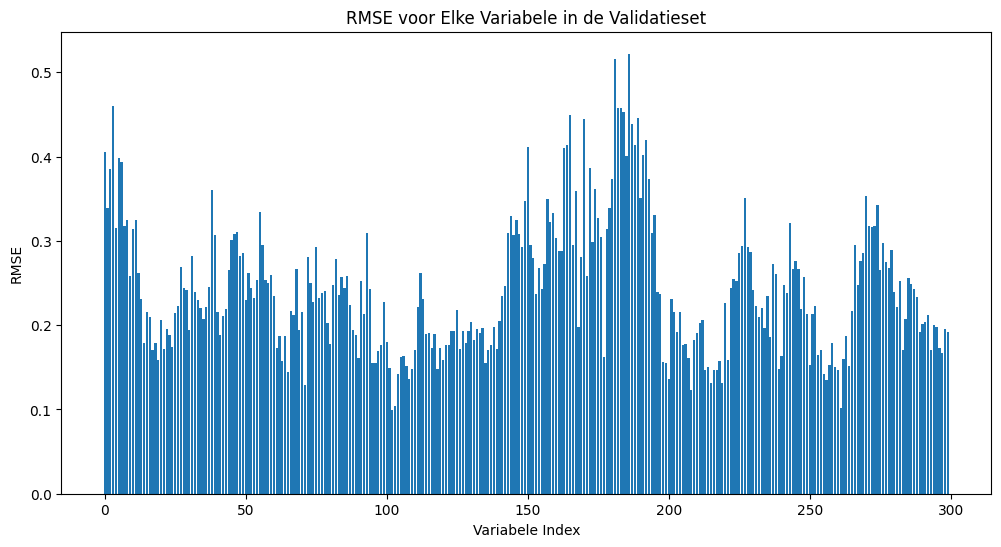

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Functies voor standaardisatie en RMSE berekening
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

# Dynamic Factor Model klasse
class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Gestandaardiseerde data vorm:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factoren vorm:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker schatting vorm:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix vorm:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat
    
    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Vorm van X voor enige operatie:", X.shape)
        print("Vorm van Y voor enige operatie:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Vorm mismatch in aantal kolommen: aanpassen van Y")
            Y = Y[:, :X.shape[1]]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Vorm mismatch in aantal rijen: aanpassen van Y")
            Y = Y[:X.shape[0], :]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Getransponeerde vorm van X:", X.T.shape)
        print("Getransponeerde vorm van Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("Het aantal rijen in X en Y moet gelijk zijn na transponeren")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("De toekomstige datum moet later zijn dan de laatste datum in de data.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)
    
# Data inladen en voorbewerken
file_path = 'C:/Thesis/03. Data/Final version data/Static.xlsx'
df_data = pd.read_excel(file_path, engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Initialiseer het model
model = DynamicFactorModel(df_data, num_factors=9)

# Bepaal de validatiedatum en splits de data
DATE_VALIDATE = pd.Period('2020-01', freq='M')
print("VALIDATIEDATUM:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Datum {DATE_VALIDATE} niet gevonden in de kolommen van de dataframe")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Controleer de voorbereide datasets
print((Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape))

# Voer PCA en Yule-Walker schatting uit op de gestandaardiseerde data
model.std_data = Y_train_other_std.T  # Zorg ervoor dat dezelfde subset data wordt gebruikt voor PCA
model.apply_pca()
model.yw_estimation()

# Controleer de resultaten na het toepassen van PCA en Yule-Walker schatting
pca_factors_shape = model.factors.shape
yw_estimation_shape = model.phi.shape

# Pas het ElasticNet-model aan met cross-validatie
data_train = model.std_data[:, :int(model.std_data.shape[1] * 0.8)].T
fac_train = model.factors.T[:int(model.factors.shape[1] * 0.8), :]

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Controleer de resultaten na het aanpassen van ElasticNet met cross-validatie
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

(pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value)

# Validatie Data
data_validate = model.std_data[:, int(model.std_data.shape[1] * 0.8):].T
fac_validate = model.factors.T[int(model.factors.shape[1] * 0.8):, :]

# Voorspel met het model
y_hat_validate = model.enet_predict(fac_validate)

# Bereken RMSE voor validatie data
rmse_value = RMSE(data_validate, y_hat_validate)

# Controleer de RMSE waarde
print(f"RMSE: {rmse_value}")

# Plot RMSE waarden
plt.figure(figsize=(12, 6))
plt.bar(range(len(rmse_value)), rmse_value)
plt.xlabel('Variabele Index')
plt.ylabel('RMSE')
plt.title('RMSE voor Elke Variabele in de Validatieset')
plt.show()


In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Functies voor standaardisatie en RMSE berekening
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE_single(data: pd.Series, estimation: pd.Series):
    error = (estimation - data) ** 2.0
    rmse = np.sqrt(error.mean())
    return rmse

# Dynamic Factor Model klasse
class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Gestandaardiseerde data vorm:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factoren vorm:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker schatting vorm:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix vorm:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat
    
    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Vorm van X voor enige operatie:", X.shape)
        print("Vorm van Y voor enige operatie:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Vorm mismatch in aantal kolommen: aanpassen van Y")
            Y = Y[:, :X.shape[1]]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Vorm mismatch in aantal rijen: aanpassen van Y")
            Y = Y[:X.shape[0], :]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Getransponeerde vorm van X:", X.T.shape)
        print("Getransponeerde vorm van Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("Het aantal rijen in X en Y moet gelijk zijn na transponeren")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("De toekomstige datum moet later zijn dan de laatste datum in de data.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)
    
# Data inladen en voorbewerken
file_path = 'C:/Thesis/03. Data/Final version data/Static.xlsx'
df_data = pd.read_excel(file_path, engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Initialiseer het model
model = DynamicFactorModel(df_data, num_factors=9)

# Bepaal de validatiedatum en splits de data
DATE_TRAIN_END = pd.Period('2019-12', freq='M')
DATE_VALIDATE_START = pd.Period('2020-01', freq='M')
TARGET_DATE = pd.Period('2023-01', freq='M')

print("EIND TRAININGSDATUM:", DATE_TRAIN_END)
print("START VALIDATIEDATUM:", DATE_VALIDATE_START)
print("DOELDATUM VOOR PREDICTIE:", TARGET_DATE)

if DATE_TRAIN_END in df_data.columns and DATE_VALIDATE_START in df_data.columns and TARGET_DATE in df_data.columns:
    date_train_end_index = df_data.columns.get_loc(DATE_TRAIN_END)
    date_validate_start_index = df_data.columns.get_loc(DATE_VALIDATE_START)
    target_date_index = df_data.columns.get_loc(TARGET_DATE)
else:
    raise ValueError(f"Een van de datums {DATE_TRAIN_END}, {DATE_VALIDATE_START} of {TARGET_DATE} niet gevonden in de kolommen van de dataframe")

Y_train_PCA = df_data.iloc[:, :date_train_end_index + 1]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_train_end_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Controleer de voorbereide datasets
print((Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape))

# Voer PCA en Yule-Walker schatting uit op de gestandaardiseerde data
model.std_data = Y_train_other_std.T  # Zorg ervoor dat dezelfde subset data wordt gebruikt voor PCA
model.apply_pca()
model.yw_estimation()

# Controleer de resultaten na het toepassen van PCA en Yule-Walker schatting
pca_factors_shape = model.factors.shape
yw_estimation_shape = model.phi.shape

# Pas het ElasticNet-model aan met cross-validatie
data_train = model.std_data[:, :date_train_end_index + 1].T
fac_train = model.factors.T[:date_train_end_index + 1, :]

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Controleer de resultaten na het aanpassen van ElasticNet met cross-validatie
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

print((pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value))

# Validatie Data
data_validate = model.std_data[:, date_validate_start_index:target_date_index + 1].T
fac_validate = model.factors.T[date_validate_start_index:target_date_index + 1, :]

# Controleer of fac_validate niet leeg is
if fac_validate.shape[0] > 0:
    y_hat_validate = model.enet_predict(fac_validate)

    # Specifieke voorspelling voor CPI_Australia in januari 2023
    cpi_australia_index = df_data.index.get_loc("CPI_Australia")
    cpi_australia_actual = df_data.iloc[cpi_australia_index, target_date_index]
    cpi_australia_pred = y_hat_validate[-1, cpi_australia_index]

    # Bereken RMSE voor de specifieke voorspelling
    rmse_cpi_australia = RMSE_single(pd.Series([cpi_australia_actual]), pd.Series([cpi_australia_pred]))

    # Controleer de RMSE waarde
    print(f"RMSE voor CPI_Australia in januari 2023: {rmse_cpi_australia}")
else:
    print("Geen data beschikbaar voor validatie.")


Gestandaardiseerde data vorm: (66, 347)
EIND TRAININGSDATUM: 2019-12
START VALIDATIEDATUM: 2020-01
DOELDATUM VOOR PREDICTIE: 2023-01
((66, 300), (54, 300), (66, 288), (54, 300), (66, 288))
PCA factoren vorm: (9, 54)
Yule-Walker schatting vorm: (10, 9)
ElasticNet B_matrix vorm: (300, 9)
((9, 54), (10, 9), (300, 9), 0.9201626505747337, array([ 0.20004999,  0.28146402,  0.26823477,  0.53987971,  0.44826524,
        0.37915417,  0.55804212,  0.37176757,  0.38549765,  0.22575151,
        0.41151811,  0.41032708,  0.45319764,  0.39946102,  0.41118913,
        0.40217847,  0.29863851,  0.33479863,  0.1368625 ,  0.39211526,
        0.37982201,  0.29131097,  0.48169657,  0.27242404,  0.45582479,
        0.29507536,  0.25323002,  0.32880839,  0.44474568,  0.52262812,
        0.63213869,  0.0581625 ,  0.52387286, -0.02210226,  0.24125971,
        0.30532875,  0.26038362,  0.39921841,  0.46987986,  0.20906212,
        0.15543694,  0.06911411,  0.04696609, -0.71652871, -0.35435342,
        0.223489

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Functies voor standaardisatie en RMSE berekening
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE_single(data: pd.Series, estimation: pd.Series):
    error = (estimation - data) ** 2.0
    rmse = np.sqrt(error.mean())
    return rmse

# Dynamic Factor Model klasse
class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Gestandaardiseerde data vorm:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factoren vorm:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker schatting vorm:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix vorm:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat
    
    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Vorm van X voor enige operatie:", X.shape)
        print("Vorm van Y voor enige operatie:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Vorm mismatch in aantal kolommen: aanpassen van Y")
            Y = Y[:, :X.shape[1]]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Vorm mismatch in aantal rijen: aanpassen van Y")
            Y = Y[:X.shape[0], :]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Getransponeerde vorm van X:", X.T.shape)
        print("Getransponeerde vorm van Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("Het aantal rijen in X en Y moet gelijk zijn na transponeren")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("De toekomstige datum moet later zijn dan de laatste datum in de data.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Data inladen en voorbewerken
file_path = 'C:/Thesis/03. Data/Final version data/Static.xlsx'
df_data = pd.read_excel(file_path, engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Initialiseer het model
model = DynamicFactorModel(df_data, num_factors=9)

# Bepaal de validatiedatum en splits de data
DATE_TRAIN_END = pd.Period('2019-12', freq='M')
DATE_VALIDATE_START = pd.Period('2020-01', freq='M')
TARGET_DATE = pd.Period('2023-01', freq='M')

print("EIND TRAININGSDATUM:", DATE_TRAIN_END)
print("START VALIDATIEDATUM:", DATE_VALIDATE_START)
print("DOELDATUM VOOR PREDICTIE:", TARGET_DATE)

if DATE_TRAIN_END in df_data.columns and DATE_VALIDATE_START in df_data.columns and TARGET_DATE in df_data.columns:
    date_train_end_index = df_data.columns.get_loc(DATE_TRAIN_END)
    date_validate_start_index = df_data.columns.get_loc(DATE_VALIDATE_START)
    target_date_index = df_data.columns.get_loc(TARGET_DATE)
else:
    raise ValueError(f"Een van de datums {DATE_TRAIN_END}, {DATE_VALIDATE_START} of {TARGET_DATE} niet gevonden in de kolommen van de dataframe")

# Print de indices en controleer de periodes
print(f"date_train_end_index: {date_train_end_index}, date_validate_start_index: {date_validate_start_index}, target_date_index: {target_date_index}")
print("Dataframe kolommen:", df_data.columns)

Y_train_PCA = df_data.iloc[:, :date_train_end_index + 1]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_train_end_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Controleer de voorbereide datasets
print((Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape))

# Voer PCA en Yule-Walker schatting uit op de gestandaardiseerde data
model.std_data = Y_train_other_std.T  # Zorg ervoor dat dezelfde subset data wordt gebruikt voor PCA
model.apply_pca()
model.yw_estimation()

# Controleer de resultaten na het toepassen van PCA en Yule-Walker schatting
pca_factors_shape = model.factors.shape
yw_estimation_shape = model.phi.shape

# Pas het ElasticNet-model aan met cross-validatie
data_train = model.std_data[:, :date_train_end_index + 1].T
fac_train = model.factors.T[:date_train_end_index + 1, :]

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Controleer de resultaten na het aanpassen van ElasticNet met cross-validatie
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

print((pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value))

# Validatie Data
# Voeg extra printstatements toe om de data te inspecteren
print(f"Startindex validatie: {date_validate_start_index}, Eindindex validatie: {target_date_index + 1}")

data_validate = model.std_data[:, date_validate_start_index:target_date_index + 1].T
fac_validate = model.factors.T[date_validate_start_index:target_date_index + 1, :]

# Controleer de dimensies van de validatiedata
print("Vorm van validatie data:", data_validate.shape)
print("Vorm van validatie factoren:", fac_validate.shape)

# Print een deel van de validatiedata om te controleren of deze correct is
print("Voorbeeld van validatiedata:", data_validate[:5])
print("Voorbeeld van validatiefactoren:", fac_validate[:5])

# Controleer of fac_validate niet leeg is
if fac_validate.shape[0] > 0:
    y_hat_validate = model.enet_predict(fac_validate)

    # Specifieke voorspelling voor CPI_Australia in januari 2023
    cpi_australia_index = df_data.index.get_loc("CPI_Australia")
    cpi_australia_actual = df_data.iloc[cpi_australia_index, target_date_index]
    cpi_australia_pred = y_hat_validate[-1, cpi_australia_index]

    # Bereken RMSE voor de specifieke voorspelling
    rmse_cpi_australia = RMSE_single(pd.Series([cpi_australia_actual]), pd.Series([cpi_australia_pred]))

    # Controleer de RMSE waarde
    print(f"RMSE voor CPI_Australia in januari 2023: {rmse_cpi_australia}")
else:
    print("Geen data beschikbaar voor validatie.")


Gestandaardiseerde data vorm: (66, 347)
EIND TRAININGSDATUM: 2019-12
START VALIDATIEDATUM: 2020-01
DOELDATUM VOOR PREDICTIE: 2023-01
date_train_end_index: 299, date_validate_start_index: 300, target_date_index: 336
Dataframe kolommen: PeriodIndex(['1995-01', '1995-02', '1995-03', '1995-04', '1995-05', '1995-06',
             '1995-07', '1995-08', '1995-09', '1995-10',
             ...
             '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
             '2023-08', '2023-09', '2023-10', '2023-11'],
            dtype='period[M]', length=347)
((66, 300), (54, 300), (66, 288), (54, 300), (66, 288))
PCA factoren vorm: (9, 54)
Yule-Walker schatting vorm: (10, 9)
ElasticNet B_matrix vorm: (300, 9)
((9, 54), (10, 9), (300, 9), 0.9201626505747337, array([ 0.20004999,  0.28146402,  0.26823477,  0.53987971,  0.44826524,
        0.37915417,  0.55804212,  0.37176757,  0.38549765,  0.22575151,
        0.41151811,  0.41032708,  0.45319764,  0.39946102,  0.41118913,
        0.402